In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from scipy.optimize import minimize
from copy import deepcopy
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from qiskit.aqua.operators import WeightedPauliOperator, MatrixOperator
from qiskit.quantum_info import Pauli
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import random
from qiskit.compiler import transpile
from qiskit.circuit import Parameter
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from qiskit.aqua.components.optimizers import ADAM
import warnings

In [6]:
warnings.simplefilter("ignore")

In [ ]:
# global変数の宣言

In [7]:
#入力xは多次元(n)で出力yはクラスラベル(onehot encoding)、qubit数はとりあえずnにする
num_class = 2
nqubit = 2
depth = 1

In [8]:
# 結果を入れるhashmap
d = {}

In [ ]:
# ここで入力データを作成

In [ ]:
# 円型、2次元のデータを作る
def make_data(num,r,seed,mag_noise=0):
    ## 乱数のシード
    random_seed = seed
    ## 乱数発生器の初期化
    np.random.seed(random_seed)
    array = []
    theta = np.linspace(0.5,2*np.pi,num)
    noise = np.random.randn(num)
    for i in range(num):
        radius = r + mag_noise * noise[i]
        a,b = radius*np.cos(theta[i]),radius*np.sin(theta[i])
        array.append([a,b])
    array = np.array(array)
    return array

In [ ]:
x_train = np.vstack((make_data(15,0.8,8,0.05),make_data(14,0.5,0,0.05))) #0.95にしておけば範囲外に出ることはなくなると思う
y_train = np.hstack((np.array([0]*15),np.array([1]*14)))

x_test = np.vstack((make_data(15,0.8,0),make_data(14,0.5,0)))
y_test = np.hstack((np.array([0]*15),np.array([1]*14)))

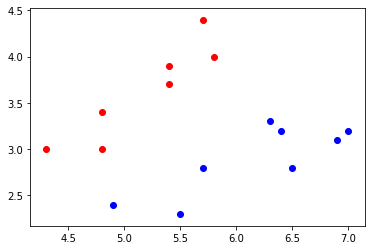

In [9]:
# iris data
iris = datasets.load_iris()
x_train = np.vstack((iris.data[10:17,[0,1]],iris.data[50:58,[0,1]]))
y_train = np.hstack((iris.target[10:17],iris.target[50:58]))

x_test = np.vstack((iris.data[40:50,[0,1]],iris.data[90:100,[0,1]]))
y_test = np.hstack((iris.target[40:50],iris.target[90:100]))

for i in range(len(x_train)):
    if y_train[i] == 0:
        plt.scatter(x_train[i][0],x_train[i][1],color = "red")
    else:
        plt.scatter(x_train[i][0],x_train[i][1],color = "blue")

In [ ]:
# wine data
# 次元削減している
pca = PCA(n_components=12)
wine = datasets.load_wine()
x,y = wine.data[:120],wine.target[:120]
x = pca.fit_transform(x)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [13]:
#これは正規化が必要な時に行う、一応やったほうが安全？
mn = MinMaxScaler(feature_range=(-1,1),copy = True)
x_train = mn.fit_transform(x_train)
x_test = mn.fit_transform(x_test)

x_train[x_train < -1] = -1
x_train[x_train > 1] = 1
x_test[x_test < -1] = -1
x_test[x_test > 1] = 1

In [ ]:
# x_train = (訓練データ数、入力次元数)、y_train = (訓練データ数)

In [14]:
numTrainData = len(x_train)  # 訓練データ数
numdim = len(x_train[0])  # 入力次元数

In [15]:
theta_list = [Parameter(str(i)) for i in range(3*nqubit*depth)]
par =  np.random.normal(0,1/np.sqrt(numTrainData),3*nqubit*depth)

In [16]:
qc_map = {}  
# x_train内のindex:対応するQuantumCircuitオブジェクト
#これはdepthやnqubitを変えるたびに初期化する
# テストデータに関しては1回ずつしか呼び出されないから特に保存しない

In [17]:
#ここでハミルトニアンを作り、使いまわす
pauli_list = []
evo_time = 10
# ΣaXに相当する部分をpauli_listに加える
for i in range(nqubit):
    a = random.uniform(-1,1)
    x = np.array([False if j != i else True for j in range(nqubit)],dtype=bool)
    z = np.array([False]*nqubit,dtype=bool)
    pauli_list.append([a,Pauli(z,x)])
# ΣJZZに相当する部分をpauli_listに加える
for i in range(nqubit):
    for k in range(i):
        J = random.uniform(-1,1)
        x = np.array([False]*nqubit,dtype=bool)
        z = np.array([True if (j == i or j == k) else False for j in range(nqubit)],dtype=bool)
        pauli_list.append([J,Pauli(z,x)])
qubitOp = WeightedPauliOperator(paulis=pauli_list)

In [18]:
def U_in(x):    #入力x(list, n dimension)、出力xをエンコードするゲートが付いた回路（QuantumCircuit）を返す
    U = QuantumCircuit(nqubit)
    for i in range(nqubit):
        angle_y = np.arcsin(x[i%numdim])
        angle_z = np.arccos(x[i%numdim]**2)
        U.ry(angle_y,[i])
        U.rz(angle_z,[i])
    
    return U

In [19]:
def ansatz(depth):  #入力パラメータ初期値のリスト、出力アンザッツが含まれた回路（QuantumCircuit）を返す
    U = QuantumCircuit(nqubit)
    U += qubitOp.evolve(
    U, evo_time, num_time_slices=1,
    expansion_mode='suzuki',
    expansion_order=3
)
    
    for i in range(nqubit):
        U.rx(theta_list[(3*nqubit*depth)+i],i)
    for i in range(nqubit):
        U.rz(theta_list[(3*nqubit*depth)+i+nqubit],i)
    for i in range(nqubit):
        U.rx(theta_list[(3*nqubit*depth)+2*nqubit+i],i)
    return U

In [20]:
def getoutput(x,init_par):   #入力x、出力yの予測値
    tupled_x = tuple(x)
    if tupled_x in qc_map:
        qc = qc_map[tupled_x]
    else:
        qc = U_in(x)
        for i in range(depth):
            qc += ansatz(i)
        qc_map[tupled_x] = qc
    
    backend = Aer.get_backend("statevector_simulator")
    job = execute(qc,backend,parameter_binds=[{theta_list[i]:init_par[i] for i in range(len(init_par))}])
    counts = job.result().get_counts()  #countsは{基底状態ベクトル:その状態になった回数}が入ってる
    res = [0]*num_class
    for i in range(num_class):
        for key in counts:
            if key[nqubit-i-1] == "0":
                res[i] += counts[key]
            else:
                res[i] -= counts[key]
    res = np.array(res)
    return res   #res[i] = <Z_i>, iは上位i番目のqubitということを表す(0-indexed)

In [21]:
def softmax(x):  #xはndarrayじゃなきゃだめ
    max_x = np.max(x)
    exp_x = np.exp(x-max_x)
    return exp_x / np.sum(exp_x)

In [22]:
def cost_func_helper(x,y,par):
    outputs = getoutput(x,par)  # 期待値のリスト
    noutputs = softmax(outputs) # それにソフトマックス関数をかけた後のリスト
    return -np.log(noutputs[y])

In [23]:
def cost_func(par):
    res = 0
    for x,y in zip(x_train,y_train):
        res += cost_func_helper(x,y,par)
    return res

In [24]:
def gene_error(par):
    # 現在のパラメータ値がparの時のテストデータに対するコスト関数の値を返す
    res = 0
    for x,y in zip(x_test,y_test):
        res += cost_func_helper(x,y,par)
    return res

In [30]:
def deriv_func(par):
    res = []
    n = len(par)
    data = it.next()  # このデータだけを使って勾配を求める
    numdata = len(data)  # バッチサイズと同じ
    
    for i in range(n):
        temp = 0
        for j in range(numdata):
            x,y = data[j][0],data[j][1]
            grads = compute_gradient1(x,par,i)
            temp += (sum(grads) - grads[y])
        res.append(temp)
    res = np.array(res)
    return res

In [26]:
def compute_gradient1(x,par,i):
    par[i] += np.pi/2
    b_plus = getoutput(x,par)  # theta_iに+pi/2した時の出力ベクトル
    par[i] -= np.pi/2
    par[i] -= np.pi/2
    b_minus = getoutput(x,par)  # theta_iに-pi/2した時の出力ベクトル
    par[i] += np.pi/2
    return (b_plus - b_minus)/2

In [27]:
class Iterator:
    def __init__(self,x,y,batch_size):
        self.x = x_train   # 訓練データの入力、ndarray
        self.y = y_train   # 訓練データの出力、ddarray
        self.batch_size = batch_size  # バッチサイズ(1以上)
        self.index = 0  # データ内のどのindexを見ているかを保持する
        self.indices = list(range(len(x_train)))  # この配列を適宜シャッフルする
        
    def next(self):   # バッチサイズ分のデータをリストに入れて変えす、途中でデータを見終わったらシャッフルする
        res = []
        for _ in range(self.batch_size):
            nx = self.x[self.indices[self.index]]
            ny = self.y[self.indices[self.index]]
            res.append((nx,ny))
            self.index += 1
            if self.index == len(self.x):
                self.index = 0
                np.random.shuffle(self.indices)
        res = np.array(res)
        return res

In [ ]:
# ここから学習

In [28]:
adam = ADAM(maxiter = 10)
it = Iterator(x = x_train,y = y_train,batch_size = 1)

In [31]:
start = time.time()

par,mincost,_ = adam.minimize(cost_func,par,deriv_func)  # (最適パラメータ、その時のコスト関数値、イテレーション数)を返す
d[depth] = d.get(depth,[]) + [(par,mincost,gene_error(par))]  # (最適パラメータ、その時のコスト関数値、その時のテストデータに対するコスト関数値)を保存

process_time = time.time() - start

print(d[depth])
print(process_time)

[(array([-0.31935741, -0.18641509, -0.27952372, -0.63031601, -0.11964538,
        0.09807278]), 11.68346016318398, 15.558052811598575)]
13.35958480834961


In [ ]:
# ここから結果の解釈(結果の図示や情報量の計算を行う)

In [32]:
def predict(x,par):   #入力x(2次元のみ)、最適化したパラメータ、出力yの予測クラスラベル
    tupled_x = tuple(x)
    if tupled_x in qc_map:
        qc = qc_map[tupled_x]
    else:
        qc = U_in(x)
        for i in range(depth):
            qc += ansatz(i)
        qc_map[tupled_x] = qc
    backend = Aer.get_backend("statevector_simulator")
    job = execute(qc,backend,parameter_binds=[{theta_list[i]:par[i] for i in range(len(par))}])
    counts = job.result().get_counts()  #countsは{基底状態ベクトル:その状態になった回数}が入ってる
    res = [0]*num_class
    for i in range(num_class):
        for key in counts:
            if key[nqubit-i-1] == "0":
                res[i] += counts[key]
            else:
                res[i] -= counts[key]
    res = np.array(res)
    res = softmax(res)
    res = list(res)
    return res.index(max(res))   #res[i] = <Z_i>にソフトマックス関数を掛けた値(iは上位i番目のqubitということを表す)

In [42]:
# 2次元の時に結果を図示できる、訓練データ用
def plot_decision_regions(par):  
    x1_min,x1_max = x_train[:,0].min(),x_train[:,0].max()  # ここを[-1,1]の範囲に収めないとnp.arcsin,np.arccosがnanとなりエラーになる
    x2_min,x2_max = x_train[:,1].min(),x_train[:,1].max()
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,0.08),
                         np.arange(x2_min,x2_max,0.08))
    points = np.array([xx1.ravel(),xx2.ravel()]).T
    z = []
    for i,j in points:
        z.append(predict([i,j],par))
    z = np.array(z)
    z = z.reshape(xx1.shape)
    
    plt.contourf(xx1,xx2,z,alpha = 0.3)
    plt.xlim(-1.3,1.3)
    plt.ylim(-1.3,1.3)
    
    for i in range(len(x_train)):
        if y_train[i]== 0:
            plt.scatter(x_train[i][0],x_train[i][1],color = "red")
        else:
            plt.scatter(x_train[i][0],x_train[i][1],color = "blue") 

In [41]:
# 2次元の時に結果を図示できる、テストデータ用
def plot_decision_regions2(par):
    x1_min,x1_max = x_train[:,0].min(),x_train[:,0].max()
    x2_min,x2_max = x_train[:,1].min(),x_train[:,1].max()
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,0.08),
                         np.arange(x2_min,x2_max,0.08))
    points = np.array([xx1.ravel(),xx2.ravel()]).T
    z = []
    for i,j in points:
        z.append(predict([i,j],par))
    z = np.array(z)
    z = z.reshape(xx1.shape)
    
    plt.contourf(xx1,xx2,z,alpha = 0.3)
    plt.xlim(-1.3,1.3)
    plt.ylim(-1.3,1.3)
    
    for i in range(len(x_test)):
        if y_test[i]== 0:
            plt.scatter(x_test[i][0],x_test[i][1],color = "red")
        else:
            plt.scatter(x_test[i][0],x_test[i][1],color = "blue") 

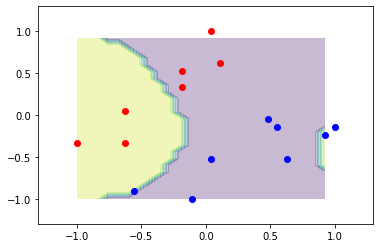

In [43]:
plot_decision_regions(par)